In [1]:
import yaml

import numpy
import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.geom as afwGeom
from lsst.afw.table import AmpInfoCatalog, AmpInfoTable, LL
from lsst.afw.cameraGeom.cameraFactory import makeDetector

In [2]:
class Ts3(cameraGeom.Camera):
    """The Test Stand 3 camera (in so far as it is a camera)
    """

    def __init__(self, cameraYamlFile):
        """Construct a TestCamera
        """
        with file(cameraYamlFile) as fd:
            cameraParams = yaml.load(fd, Loader=yaml.Loader)

        plateScale = afwGeom.Angle(cameraParams["plateScale"], afwGeom.arcseconds)
        radialCoeffs = numpy.array(cameraParams["radialCoeffs"])/plateScale.asRadians()
        focalPlaneToPupil = afwGeom.RadialXYTransform(radialCoeffs)
        pupilToFocalPlane = afwGeom.InvertedXYTransform(focalPlaneToPupil)
        cameraTransformMap = cameraGeom.CameraTransformMap(cameraGeom.FOCAL_PLANE,
                                                           {cameraGeom.PUPIL: pupilToFocalPlane})
        detectorList = self._makeDetectorList(cameraParams["CCDs"], pupilToFocalPlane, plateScale)
        cameraGeom.Camera.__init__(self, "ts3", detectorList, cameraTransformMap)

    def _makeDetectorList(self, ccdParams, focalPlaneToPupil, plateScale):
        """!Make a list of detectors
        @param[in] ccdParams  Dict of YAML descriptions of CCDs
        @param[in] focalPlaneToPupil  lsst.afw.geom.XYTransform from FOCAL_PLANE to PUPIL coordinates
        @param[in] plateScale  plate scale, in angle on sky/mm
        @return a list of detectors (lsst.afw.cameraGeom.Detector)
        """
        detectorList = []
        detectorConfigList = self._makeDetectorConfigList(ccdParams)
        for ccd, detectorConfig in zip(ccdParams.values(), detectorConfigList):
            ampInfoCatalog = self._makeAmpInfoCatalog(ccd)
            detector = makeDetector(detectorConfig, ampInfoCatalog, focalPlaneToPupil)
            detectorList.append(detector)
        return detectorList

    def _makeDetectorConfigList(self, ccdParams):
        """!Make a list of detector configs

        @return a list of detector configs (lsst.afw.cameraGeom.DetectorConfig)
        """
        detectorConfigs = []
        for name, ccd in ccdParams.items():
            detectorConfig = cameraGeom.DetectorConfig()
            detectorConfigs.append(detectorConfig)

            detectorConfig.name = name
            detectorConfig.id = ccd['id']
            detectorConfig.serial = ccd['serial']
            detectorConfig.detectorType = ccd['detectorType']
            # This is the orientation we need to put the serial direction along the x-axis
            detectorConfig.bbox_x0, detectorConfig.bbox_y0 = ccd['bbox'][0]
            detectorConfig.bbox_x1, detectorConfig.bbox_y1 = ccd['bbox'][1]
            detectorConfig.pixelSize_x, detectorConfig.pixelSize_y = ccd['pixelSize']
            detectorConfig.transformDict.nativeSys = ccd['transformDict']['nativeSys']
            transforms = ccd['transformDict']['transforms']
            detectorConfig.transformDict.transforms = None if transforms == 'None' else transforms
            detectorConfig.refpos_x, detectorConfig.refpos_y = ccd['refpos']
            detectorConfig.offset_x, detectorConfig.offset_y = ccd['offset']
            detectorConfig.transposeDetector = ccd['transposeDetector']
            detectorConfig.pitchDeg = ccd['pitch']
            detectorConfig.yawDeg = ccd['yaw']
            detectorConfig.rollDeg = ccd['roll']
        
        return detectorConfigs

    def _makeAmpInfoCatalog(self, ccd):
        """Construct an amplifier info catalog
        """
        # Much of this will need to be filled in when we know it.
        assert len(ccd['amplifiers']) > 0
        amp = ccd['amplifiers'].values()[0]
        xDataExtent, yDataExtent = amp['dataExtent']  # trimmed

        extended = amp['extended']
        h_overscan = amp['h_overscan']
        v_overscan = amp['v_overscan']
        nRowPreParallelTransfer = amp['nRowPreParallelTransfer']

        xRawExtent = extended                + xDataExtent + h_overscan
        yRawExtent = nRowPreParallelTransfer + yDataExtent + v_overscan
        
        from lsst.afw.table import LL, LR, UL, UR
        readCorners = dict(LL = LL, LR = LR, UL = UL, UR = UR)

        schema = AmpInfoTable.makeMinimalSchema()

        linThreshKey = schema.addField('linearityThreshold', type=float)
        linMaxKey = schema.addField('linearityMaximum', type=float)
        linUnitsKey = schema.addField('linearityUnits', type=str, size=9)
        # end placeholder
        self.ampInfoDict = {}
        ampCatalog = AmpInfoCatalog(schema)
        for name, amp in ccd['amplifiers'].items():
            record = ampCatalog.addNew()
            record.setName(name)

            ix, iy = amp['ixy']
            record.setBBox(afwGeom.BoxI(
                    afwGeom.PointI(ix*xDataExtent, iy*yDataExtent), afwGeom.ExtentI(xDataExtent, yDataExtent),
                ))

            record.setRawBBox(afwGeom.Box2I(
                afwGeom.Point2I(0, 0),
                afwGeom.Extent2I(xRawExtent, yRawExtent),
            ))
            record.setRawDataBBox(afwGeom.Box2I(
                afwGeom.Point2I(extended, nRowPreParallelTransfer),
                afwGeom.Extent2I(xDataExtent, yDataExtent),
            ))
            record.setRawHorizontalOverscanBBox(afwGeom.Box2I(
                afwGeom.Point2I(extended + xDataExtent, nRowPreParallelTransfer),
                afwGeom.Extent2I(h_overscan, yDataExtent),
            ))
            record.setRawVerticalOverscanBBox(afwGeom.Box2I(
                afwGeom.Point2I(extended, nRowPreParallelTransfer + yDataExtent),
                afwGeom.Extent2I(xDataExtent, v_overscan),
            ))
            record.setRawPrescanBBox(afwGeom.Box2I())   # Should be set by an isrTask configuration
            record.setRawXYOffset(afwGeom.Extent2I(ix*xRawExtent, iy*yRawExtent))
            record.setReadoutCorner(readCorners[amp['readCorner']])
            record.setGain(amp['gain'])
            record.setReadNoise(amp['readNoise'])
            record.setSaturation(amp['saturation'])
            record.setHasRawInfo(True)
            # flip data when assembling if in top of chip
            flipX, flipY = amp.get("flipXY")

            record.setRawFlipX(flipX)
            record.setRawFlipY(flipY)
            # linearity placeholder stuff
            record.setLinearityCoeffs([float(val) for val in amp['linearityCoeffs']])
            record.setLinearityType(amp['linearityType'])
            record.set(linThreshKey, float(amp['linearityThreshold']))
            record.set(linMaxKey, float(amp['linearityMax']))
            record.set(linUnitsKey, "DN")
        return ampCatalog

ts3 = Ts3("camera.yaml")

In [4]:
import lsst.afw.cameraGeom.utils as cgUtils
import lsst.afw.display as afwDisplay

disp = afwDisplay.Display(1, 'ds9')

if True:
    mos = cgUtils.showCamera(ts3, overlay=True, display=disp)
else:
    mos = cgUtils.showCcd(ts3[1], overlay=True, display=disp)

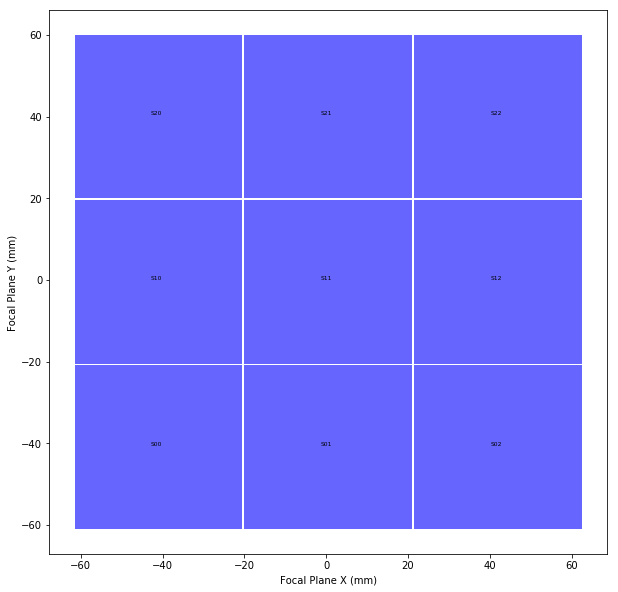

In [6]:
cgUtils.plotFocalPlane(ts3)

In [30]:
#from lsst.obs.ts3 import Ts3 as oTs3
import lsst.obs.ts3.ts3 as ots3

ots3 = ots3.Ts3()

disp2 = afwDisplay.Display(2, 'ds9')

mos = cgUtils.showCcd(list(ots3)[0], overlay=True, display=disp2)